In [1]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
import torch.nn as nn
from models.mae_with_region_cross_att_stitcher_simple_decoder import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.chaotic_rnn_loader import *
from utils.mask import get_force_mask
import matplotlib.pyplot as plt
import seaborn as sns
from utils.metric_utils import Poisson_fraction_deviance_explained, GLM_Poisson, get_deviance_explained


In [ ]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'

In [7]:
eids = list(np.arange(10, dtype=int)) 
base_path = '/work/hdd/bdye/jxia4/results/mae_results/'
num_train_sessions = len(eids)

mask_mode = 'region'

region_channel_num = 24 # number of region channels in decoder
region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5

num_epochs = 1000
batch_size = 16
use_wandb = False
consistency = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_region_stitcher_cross_att_simple_decoder.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['decoder']['stitcher']['n_channels_per_region'] = region_channel_num
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['model']['encoder']['transformer']['n_layers'] = n_layers
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

set_seed(config.seed)   
dataloader, num_neurons, datasets, area_ind_list_list, record_info_list = make_chaotic_rnn_loader(eids, batch_size=batch_size)
set_seed(config.seed)
areaoi_ind = np.array([0,1,2,3,4])
n_area = len(areaoi_ind)

meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = eids

config = update_config(config, meta_data) # so that everything is saved in the config file

test_dataloader = dataloader['test']


seed set to 42
Loading existing data session  0
Loading existing data session  1
Loading existing data session  2
Loading existing data session  3
Loading existing data session  4
Loading existing data session  5
Loading existing data session  6
Loading existing data session  7
Loading existing data session  8
Loading existing data session  9
num_neurons:  [169, 162, 77, 121, 117, 128, 180, 111, 116, 152]
num_trials:  {'train': [167, 165, 147, 136, 172, 158, 131, 142, 169, 122], 'val': [56, 55, 49, 46, 58, 53, 44, 48, 56, 41], 'test': [56, 55, 49, 46, 58, 53, 44, 48, 57, 41]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test
seed set to 42


In [4]:
#read in factors_test.npy
factors_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions_low_fr/factors_test.npy', allow_pickle=True).item()
rates_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions_low_fr/rates_test.npy', allow_pickle=True).item()

In [3]:
#load lfads dfe files
dfe_lfads_pred = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions_low_fr/dfe/lfads_dfe_pred.npy', allow_pickle=True).item()
fr_lfads_pred_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions_low_fr/dfe/lfads_fr_pred_test.npy', allow_pickle=True).item()

In [5]:
dfe_RRR_pred = np.load('/work/hdd/bdye/jxia4/data/RRR_results_synthetic_updated/dfe/RRR_dfe_pred.npy', allow_pickle=True).item()
fr_RRR_pred_test = np.load('/work/hdd/bdye/jxia4/data/RRR_results_synthetic_updated/dfe/RRR_fr_pred_test.npy', allow_pickle=True).item()

In [5]:
def get_pred_fr_and_dfe(factors_region, spikes_region, n_trial_train, device):
    '''
    factors_region: B x T x C
    spikes_region: B x T x N
    n_trial_train: int
    device: torch.device

    return: fr_pred_test, dfe_test
    '''

    factors_region_train = factors_region[:n_trial_train]
    spikes_region_train = spikes_region[:n_trial_train]

    factors_region_test = factors_region[n_trial_train:]
    spikes_region_test = spikes_region[n_trial_train:]

    fr_pred_train, weight, bias, dfe_train = get_deviance_explained(factors_region_train, spikes_region_train, device, verbose=True)
    fr_pred_test = torch.exp(factors_region_test @ weight + bias[None, None, :])

    if torch.any(torch.isnan(fr_pred_test)):
        print('nan in fr_pred_test using recorded data', ', session ', eid)
        return fr_pred_test, spikes_region_test, None

    dfe_test = Poisson_fraction_deviance_explained(fr_pred_test.cpu().detach().numpy(), spikes_region_test.cpu().detach().numpy())
    
    return fr_pred_test, spikes_region_test, dfe_test

In [6]:
accelerator = Accelerator()
device = accelerator.device
print(device)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


cuda


In [ ]:
## run this cell to calculate and save performance metrics for LFADS factors.

# set_seed(config.seed)  

# dfe_lfads_pred = {}
# fr_lfads_pred_test = {}


# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]


#         spikes_data = batch['spikes_data']
#         print('batch spike', spikes_data.shape)
        
#         spikes_data_lfads = rates_test[eid]
#         if spikes_data_lfads.shape != spikes_data.shape:
#             print('spike data shape not match', spikes_data_lfads.shape, spikes_data.shape)
#             break
        
#         dfe_lfads_pred[eid] = {}
#         fr_lfads_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         lfads_factors = torch.from_numpy(factors_test[eid]).to(device)

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(lfads_factors, spikes_region, n_trial_train, device)

#             dfe_lfads_pred[eid][area_ind] = dfe_test
#             fr_lfads_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/lfads_results/synthetic_10_sessions_low_fr/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'lfads_dfe_pred.npy', dfe_lfads_pred)
# np.save(save_path+'lfads_fr_pred_test.npy', fr_lfads_pred_test)

In [7]:
RRR_factors_area_ind = np.load('/work/hdd/bdye/jxia4/data/RRR_results_synthetic_updated/preds_lat_area.npy', allow_pickle=True)
print(RRR_factors_area_ind.shape)

with open('/work/hdd/bdye/jxia4/data/RRR_results_synthetic_updated/preds_lat.pkl', 'rb') as f:
    RRR_factors = pickle.load(f)

(120,)


In [ ]:
## run this cell to calculate and save performance metrics for RRR factors.

# set_seed(config.seed)  

# dfe_RRR_pred = {}
# fr_RRR_pred_test = {}

# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]


#         spikes_data = batch['spikes_data']

#         dfe_RRR_pred[eid] = {}
#         fr_RRR_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             print('area_ind', area_ind)
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue
            
#             RRR_factors_region = torch.from_numpy(RRR_factors[str(eid)][:,:,RRR_factors_area_ind==area_ind]).to(device)

#             #scale and center RRR_factors_region to encourage convergence
#             mean_tmp = torch.mean(RRR_factors_region, dim=(0,1), keepdim=True)
#             std_tmp = torch.std(RRR_factors_region, dim=(0,1), keepdim=True)
#             RRR_factors_region = (RRR_factors_region - mean_tmp) / std_tmp

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(RRR_factors_region, spikes_region, n_trial_train, device)

#             dfe_RRR_pred[eid][area_ind] = dfe_test
#             fr_RRR_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/RRR_results_synthetic_updated/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'RRR_dfe_pred.npy', dfe_RRR_pred)
# np.save(save_path+'RRR_fr_pred_test.npy', fr_RRR_pred_test)

In [8]:
consistency = True
with_reg = True
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_3_min_neg_3/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
dfe_no_mask_from_record_to_unrecord = np.load(save_path + 'dfe_no_mask_from_record_to_unrecord.npy', allow_pickle=True).item()
dfe_gt = np.load(save_path + 'dfe_gt.npy', allow_pickle=True).item()

baseline_no_mask_fr_pred_test = np.load(save_path + 'baseline_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
spike_test = np.load(save_path + 'spike_test_save.npy', allow_pickle=True).item()


In [9]:
consistency = True
with_reg = False
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_3_min_neg_3/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred_no_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_no_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()


In [10]:
consistency = False
with_reg = True
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_3_min_neg_3/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred_wo_consistency_with_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_wo_consistency_with_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()

consistency = False
with_reg = False
save_path = f'{base_path}eval/chaotic_rnn_g3_01_log_fr_max_3_min_neg_3/with_reg_{with_reg}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/region_factors_{region_channel_num}/dfe/'
    
dfe_no_mask_pred_wo_consistency_wo_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_wo_consistency_wo_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()


In [11]:
#prepare for bar plot
dfe_mae_combine_sessions = []
dfe_glm_combine_sessions = []
dfe_mae_w_consist_wo_reg_combine_sessions = []
dfe_mae_wo_consistency_w_reg_combine_sessions = []

dfe_mae_wo_consistency_wo_reg_combine_sessions = []


dfe_gt_combine_sessions = []
dfe_lfads_combine_sessions = []
dfe_RRR_combine_sessions = []

for eid_ind in range(10):
    eid = eids[eid_ind]
    omit_area_inds = record_info_list[eid_ind]['omit_region']

    for area_ind in omit_area_inds:
        if area_ind not in dfe_no_mask_pred[eid].keys():
            print(eid)
            print('no area_ind in dfe_no_mask_pred')
            continue

        if dfe_no_mask_pred[eid][area_ind] is None:
            print(eid)
            print('dfe_no_mask_pred[eid][area_ind] is None')
            continue

        dfe_mae_combine_sessions.append(dfe_no_mask_pred[eid][area_ind])
        dfe_glm_combine_sessions.append(dfe_no_mask_from_record_to_unrecord[eid][area_ind])
        dfe_mae_wo_consistency_w_reg_combine_sessions.append(dfe_no_mask_pred_wo_consistency_with_reg[eid][area_ind])
        dfe_mae_wo_consistency_wo_reg_combine_sessions.append(dfe_no_mask_pred_wo_consistency_wo_reg[eid][area_ind])
        dfe_mae_w_consist_wo_reg_combine_sessions.append(dfe_no_mask_pred_no_reg[eid][area_ind])
        dfe_gt_combine_sessions.append(dfe_gt[eid][area_ind])
        dfe_lfads_combine_sessions.append(dfe_lfads_pred[eid][area_ind])
        dfe_RRR_combine_sessions.append(dfe_RRR_pred[eid][area_ind])


dfe_mae_combine_sessions = np.concatenate(dfe_mae_combine_sessions)
dfe_mae_w_consist_wo_reg_combine_sessions = np.concatenate(dfe_mae_w_consist_wo_reg_combine_sessions)
dfe_mae_wo_consistency_w_reg_combine_sessions = np.concatenate(dfe_mae_wo_consistency_w_reg_combine_sessions)
dfe_mae_wo_consistency_wo_reg_combine_sessions = np.concatenate(dfe_mae_wo_consistency_wo_reg_combine_sessions)

dfe_glm_combine_sessions = np.concatenate(dfe_glm_combine_sessions)
dfe_gt_combine_sessions = np.concatenate(dfe_gt_combine_sessions)
dfe_lfads_combine_sessions = np.concatenate(dfe_lfads_combine_sessions)
dfe_RRR_combine_sessions = np.concatenate(dfe_RRR_combine_sessions)

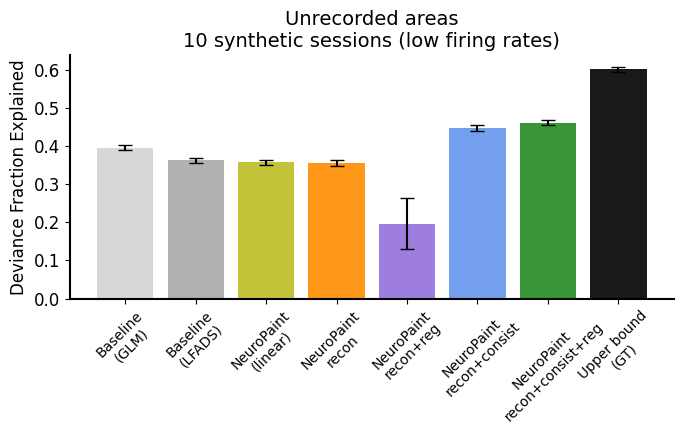

In [ ]:
# Prepare data for LFADS and MAE
colors = ['lightgray', 'darkgray', 'tab:olive', 'darkorange','mediumpurple','cornflowerblue', 'forestgreen', 'black']  # Colors for GLM, MAE, gt
methods = ['Baseline\n(GLM)', 'Baseline\n(LFADS)', 'NeuroPaint\n(linear)', 'NeuroPaint\nrecon','NeuroPaint\nrecon+reg', 'NeuroPaint\nrecon+consist', 'NeuroPaint\nrecon+consist+reg', 'Upper bound\n(GT)']  

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(dfe_glm_combine_sessions),
    np.nanmean(dfe_lfads_combine_sessions),
    np.nanmean(dfe_RRR_combine_sessions),
    np.nanmean(dfe_mae_wo_consistency_wo_reg_combine_sessions),
    np.nanmean(dfe_mae_wo_consistency_w_reg_combine_sessions),
    np.nanmean(dfe_mae_w_consist_wo_reg_combine_sessions),
    np.nanmean(dfe_mae_combine_sessions),
    np.nanmean(dfe_gt[eid][area_ind])  # GT is the last one
    
]

errors = [
    np.nanstd(dfe_glm_combine_sessions) / np.sqrt(len(dfe_glm_combine_sessions)),
    np.nanstd(dfe_lfads_combine_sessions) / np.sqrt(len(dfe_lfads_combine_sessions)),
    np.nanstd(dfe_RRR_combine_sessions) / np.sqrt(len(dfe_RRR_combine_sessions)),
    np.nanstd(dfe_mae_wo_consistency_wo_reg_combine_sessions) / np.sqrt(len(dfe_mae_wo_consistency_wo_reg_combine_sessions)),
    np.nanstd(dfe_mae_wo_consistency_w_reg_combine_sessions) / np.sqrt(len(dfe_mae_wo_consistency_w_reg_combine_sessions)),
    np.nanstd(dfe_mae_w_consist_wo_reg_combine_sessions) / np.sqrt(len(dfe_mae_w_consist_wo_reg_combine_sessions)),
    np.nanstd(dfe_mae_combine_sessions) / np.sqrt(len(dfe_mae_combine_sessions)),
    np.nanstd(dfe_gt_combine_sessions) / np.sqrt(len(dfe_gt_combine_sessions))                                                                     
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10, rotation = 45)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
ax.set_title('Unrecorded areas\n10 synthetic sessions (low firing rates)', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + f'fig2_supp_w_RRR/synthetic_dfe_barplot_linear_neuropaint.pdf', transparent=True)

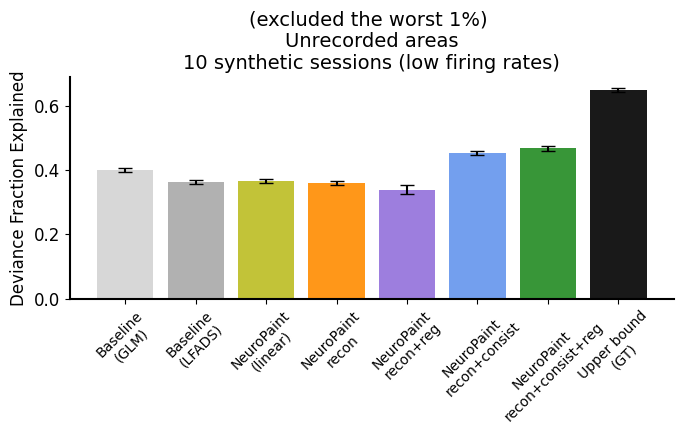

In [ ]:
# Filter data to include only values greater than 0

filter_percent = 1
# filtered_RRR = dfe_RRR_combine_sessions_remove_inf[dfe_RRR_combine_sessions_remove_inf > np.quantile(dfe_RRR_combine_sessions_remove_inf, 0.01*filter_percent)]
# filtered_lfads = dfe_lfads_combine_sessions_remove_inf[dfe_lfads_combine_sessions_remove_inf > np.quantile(dfe_lfads_combine_sessions_remove_inf, 0.01*filter_percent)]
# filtered_mae = dfe_mae_combine_sessions_remove_inf[dfe_mae_combine_sessions_remove_inf > np.quantile(dfe_mae_combine_sessions_remove_inf, 0.01*filter_percent)]
filtered_GLM = dfe_glm_combine_sessions[dfe_glm_combine_sessions > np.quantile(dfe_glm_combine_sessions, 0.01*filter_percent)]
filtered_mae = dfe_mae_combine_sessions[dfe_mae_combine_sessions > np.quantile(dfe_mae_combine_sessions, 0.01*filter_percent)]
filtered_mae_w_consist_wo_reg = dfe_mae_w_consist_wo_reg_combine_sessions[dfe_mae_w_consist_wo_reg_combine_sessions > np.quantile(dfe_mae_w_consist_wo_reg_combine_sessions, 0.01*filter_percent)]
filtered_mae_wo_consistency_w_reg = dfe_mae_wo_consistency_w_reg_combine_sessions[dfe_mae_wo_consistency_w_reg_combine_sessions > np.quantile(dfe_mae_wo_consistency_w_reg_combine_sessions, 0.01*filter_percent)]
filtered_mae_wo_consistency_wo_reg = dfe_mae_wo_consistency_wo_reg_combine_sessions[dfe_mae_wo_consistency_wo_reg_combine_sessions > np.quantile(dfe_mae_wo_consistency_wo_reg_combine_sessions, 0.01*filter_percent)]
filtered_gt = dfe_gt_combine_sessions[dfe_gt_combine_sessions > np.quantile(dfe_gt_combine_sessions, 0.01*filter_percent)]

filtered_lfads = dfe_lfads_combine_sessions[dfe_lfads_combine_sessions > np.quantile(dfe_lfads_combine_sessions, 0.01*filter_percent)]
filtered_RRR = dfe_RRR_combine_sessions[dfe_RRR_combine_sessions > np.quantile(dfe_RRR_combine_sessions, 0.01*filter_percent)]


# Prepare data for LFADS and MAE
colors = ['lightgray', 'darkgray', 'tab:olive', 'darkorange','mediumpurple','cornflowerblue',  'forestgreen', 'black']  # Colors for GLM, MAE, gt
methods = ['Baseline\n(GLM)', 'Baseline\n(LFADS)', 'NeuroPaint\n(linear)', 'NeuroPaint\nrecon','NeuroPaint\nrecon+reg', 'NeuroPaint\nrecon+consist', 'NeuroPaint\nrecon+consist+reg', 'Upper bound\n(GT)']  

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(filtered_GLM),
    np.nanmean(filtered_RRR),
    np.nanmean(filtered_lfads),
    np.nanmean(filtered_mae_wo_consistency_wo_reg),
    np.nanmean(filtered_mae_wo_consistency_w_reg),
    np.nanmean(filtered_mae_w_consist_wo_reg),
    np.nanmean(filtered_mae),
    np.nanmean(filtered_gt)  # GT is the last one
]

errors = [
    np.nanstd(filtered_GLM) / np.sqrt(len(filtered_GLM)),
    np.nanstd(filtered_RRR) / np.sqrt(len(filtered_RRR)),
    np.nanstd(filtered_lfads) / np.sqrt(len(filtered_lfads)),
    np.nanstd(filtered_mae_wo_consistency_wo_reg) / np.sqrt(len(filtered_mae_wo_consistency_wo_reg)),
    np.nanstd(filtered_mae_wo_consistency_w_reg) / np.sqrt(len(filtered_mae_wo_consistency_w_reg)),
    np.nanstd(filtered_mae_w_consist_wo_reg) / np.sqrt(len(filtered_mae_w_consist_wo_reg)),
    np.nanstd(filtered_mae) / np.sqrt(len(filtered_mae)),
    np.nanstd(filtered_gt) / np.sqrt(len(filtered_gt))
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10, rotation = 45)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
#ax.set_title('LFADS vs MAE \n(Filtered > 5% quantile)', fontsize=14)
ax.set_title(f'(excluded the worst {filter_percent}%) \nUnrecorded areas\n10 synthetic sessions (low firing rates)', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + f'fig2_supp_w_RRR/synthetic_dfe_barplot_with_filtered_{filter_percent}_linear_neuropaint.pdf', transparent=True)